## Problem 1

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize
from ann import NeuralNet, pack_params, unpack_params

In [2]:
# Trial solution satisfying psi(0) = 1
def psi_trial(x, net):
    return 1 + x * net.forward(x)

In [3]:
# Derivative of trial solution
def d_psi_trial(x, net):
    return net.forward(x) + x * net.derivative(x)

In [4]:
def ode_rhs(x, psi):
    term = (1 + 3 * x**2) / (1 + x + x**3)
    return x**3 + 2 * x + x**2 * term - (x + term) * psi

In [5]:
def residual(x, net):
    psi = psi_trial(x, net)
    dpsi = d_psi_trial(x, net)
    return dpsi - ode_rhs(x, psi)

In [6]:
def loss_fn(x, net):
    return np.mean(residual(x, net)**2)

In [7]:
def objective(params, net, x_train):
    unpack_params(net, params)
    return loss_fn(x_train, net)

In [8]:
def train_network(n_hidden, x_train):
    net = NeuralNet(n_hidden=n_hidden, n_output=1, activation='tanh')
    params0 = pack_params(net)
    result = minimize(objective, params0, args=(net, x_train),
                      method='BFGS', options={'disp': False, 'maxiter': 1000})
    unpack_params(net, result.x)
    return net


In [9]:
def exact_solution(x):
    return np.exp(-x**2 / 2) / (1 + x + x**3) + x**2

In [10]:
# Training points
x_train = np.linspace(0, 1, 50).reshape(-1, 1)

# Testing Points
x_test = np.linspace(0, 1, 200).reshape(-1, 1)
psi_exact = exact_solution(x_test).flatten()

In [11]:
nets = {
    5: train_network(5, x_train),
    10: train_network(10, x_train),
    20: train_network(20, x_train),
}

In [12]:
print(f"Loss (5 neurons): {loss_fn(x_train, nets[5])}")
print(f"Loss (10 neurons): {loss_fn(x_train, nets[10])}")
print(f"Loss (20 neurons): {loss_fn(x_train, nets[20])}")

Loss (5 neurons): 3.50221371216229e-07
Loss (10 neurons): 9.279003688853943e-08
Loss (20 neurons): 1.0993749130706694e-06


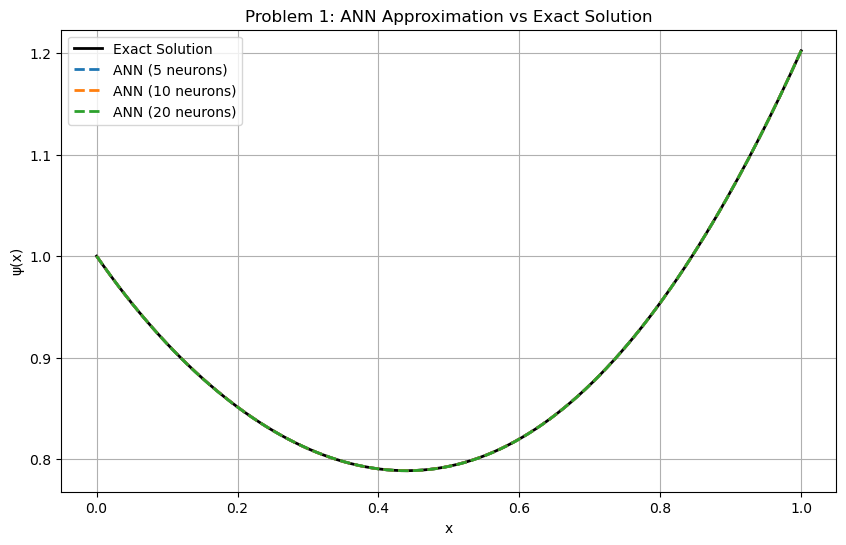

In [13]:
plt.figure(figsize=(10, 6))
plt.plot(x_test, psi_exact, 'k', label='Exact Solution', linewidth=2)

for n_hidden, net in nets.items():
    psi_pred = psi_trial(x_test, net).flatten()
    plt.plot(x_test, psi_pred, '--', label=f'ANN ({n_hidden} neurons)', linewidth=2)

plt.xlabel("x")
plt.ylabel("ψ(x)")
plt.title("Problem 1: ANN Approximation vs Exact Solution")
plt.grid(True)
plt.legend()
plt.show()


 Training ANN with 5 neurons


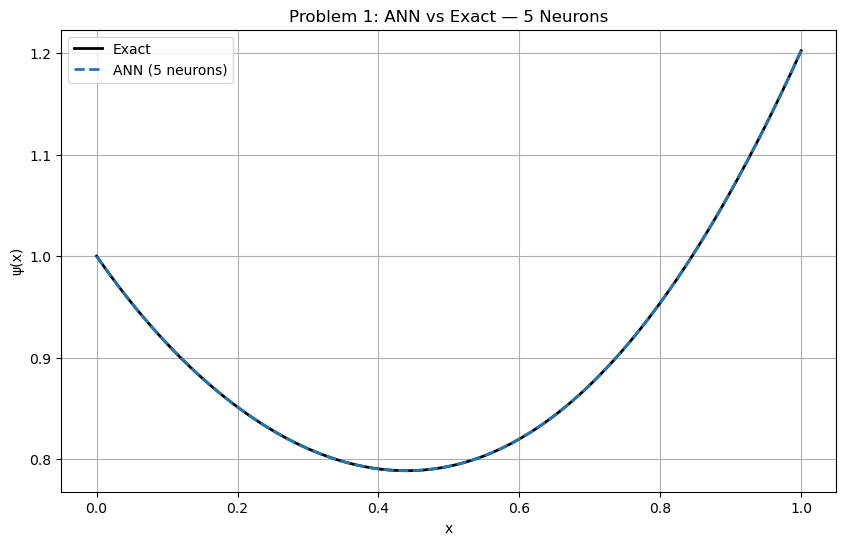

 Residual Loss: 3.247841e-07 | MSE: 1.265900e-09

 Training ANN with 10 neurons


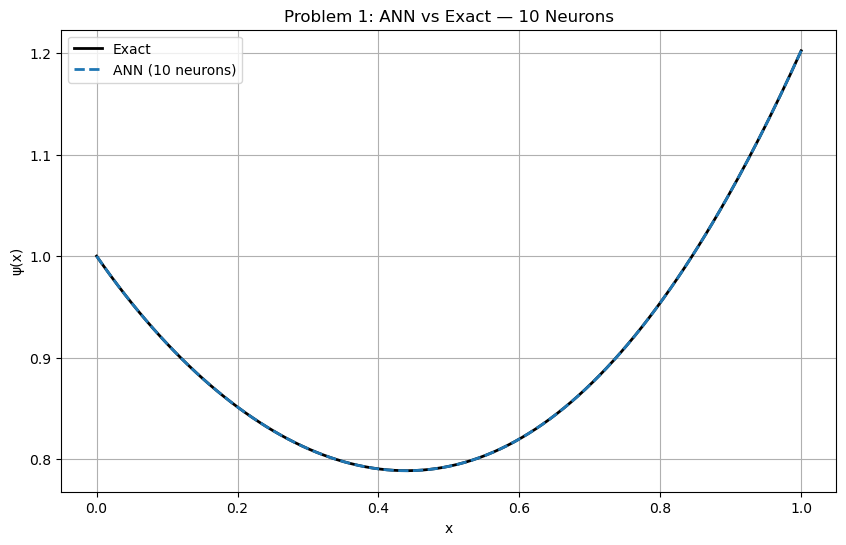

 Residual Loss: 9.617957e-08 | MSE: 6.641942e-10

 Training ANN with 20 neurons


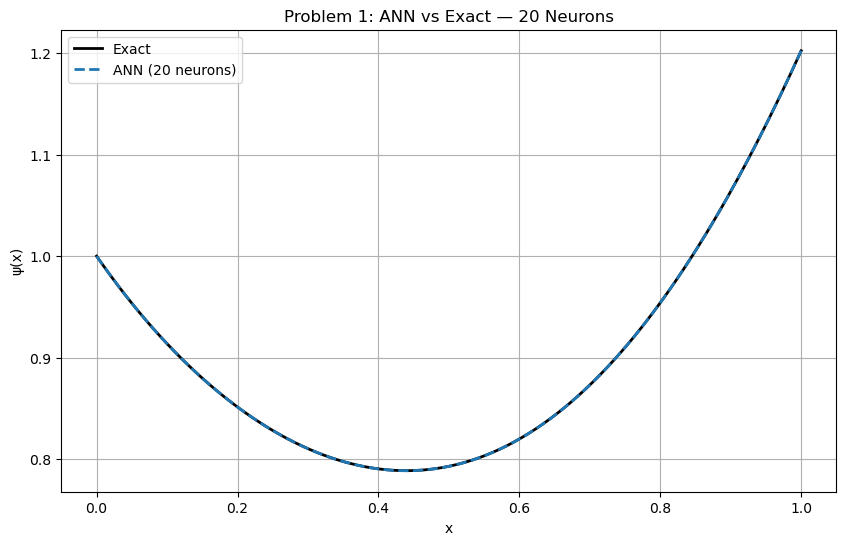

 Residual Loss: 1.163175e-07 | MSE: 7.149231e-10


In [14]:
psi_exact = exact_solution(x_test).flatten()

neurons = [5, 10, 20]

for n_hidden in neurons:
    print(f"\n Training ANN with {n_hidden} neurons")

    net = NeuralNet(n_hidden=n_hidden, n_output=1, activation='tanh')
    params0 = pack_params(net)

    result = minimize(objective, params0, args=(net, x_train),
                      method='BFGS', options={'disp': False, 'maxiter': 3000})
    unpack_params(net, result.x)

    psi_pred = psi_trial(x_test, net).flatten()
    mse = np.mean((psi_pred - psi_exact)**2)
    loss = loss_fn(x_train, net)

    plt.figure(figsize=(10, 6))
    plt.plot(x_test, psi_exact, 'k', label='Exact', linewidth=2)
    plt.plot(x_test, psi_pred, '--', label=f'ANN ({n_hidden} neurons)', linewidth=2)
    plt.title(f"Problem 1: ANN vs Exact — {n_hidden} Neurons")
    plt.xlabel('x')
    plt.ylabel('ψ(x)')
    plt.grid(True)
    plt.legend()
    plt.show()
    print(f" Residual Loss: {loss:.6e} | MSE: {mse:.6e}")


**Loss Functions**

In [15]:
def loss_mse(x, net):
    return np.mean(residual(x, net)**2)

def loss_mae(x, net):
    return np.mean(np.abs(residual(x, net)))

def loss_huber(x, net, delta=1e-2):
    r = residual(x, net)
    return np.mean(np.where(np.abs(r) <= delta,
                            0.5 * r**2,
                            delta * (np.abs(r) - 0.5 * delta)))

def loss_logcosh(x, net):
    r = residual(x, net)
    return np.mean(np.log(np.cosh(r)))

def loss_exp(x, net):
    r = residual(x, net)
    return np.mean(1 - np.exp(-r**2))

def loss_fn(x, net, loss_type='mse'):
    if loss_type == 'mse':
        return loss_mse(x, net)
    elif loss_type == 'mae':
        return loss_mae(x, net)
    elif loss_type == 'huber':
        return loss_huber(x, net)
    elif loss_type == 'logcosh':
        return loss_logcosh(x, net)
    elif loss_type == 'exp':
        return loss_exp(x, net)
    else:
        raise ValueError("Invalid loss type")

In [16]:
def objective(params, net, x_train, loss_type='mse'):
    unpack_params(net, params)
    return loss_fn(x_train, net, loss_type)

In [17]:
net = NeuralNet(n_hidden=10, n_output=1, activation='tanh')
params0 = pack_params(net)

result = minimize(objective, params0, args=(net, x_train,'mse'),
                  method='BFGS', options={'disp': True, 'maxiter': 3000})
unpack_params(net, result.x)

Optimization terminated successfully.
         Current function value: 0.000004
         Iterations: 52
         Function evaluations: 1856
         Gradient evaluations: 58


In [18]:
loss_types = ['mse', 'huber', 'logcosh', 'exp']
results = {}
x_train = np.linspace(0, 1, 50).reshape(-1, 1)
x_test = np.linspace(0, 1, 200).reshape(-1, 1)

def exact_solution(x):
    return np.exp(-x**2 / 2) / (1 + x + x**3) + x**2

psi_exact = exact_solution(x_test).flatten()

for loss_type in loss_types:
    print(f"\n Training with {loss_type.upper()} loss")
    net = NeuralNet(n_hidden=10, n_output=1, activation='sigmoid')
    params0 = pack_params(net)

    result = minimize(objective, params0, args=(net, x_train, loss_type),
                      method='BFGS', options={'disp': False, 'maxiter': 3000})
    unpack_params(net, result.x)

    psi_pred = psi_trial(x_test, net).flatten()
    mse = np.mean((psi_pred - psi_exact)**2)

    results[loss_type] = {
        'net': net,
        'pred': psi_pred,
        'mse': mse
    }

    print(f" MSE vs Exact: {mse:.6e}")



 Training with MSE loss
 MSE vs Exact: 1.430900e-09

 Training with HUBER loss
 MSE vs Exact: 1.976847e-08

 Training with LOGCOSH loss
 MSE vs Exact: 4.947133e-08

 Training with EXP loss
 MSE vs Exact: 3.353377e-08


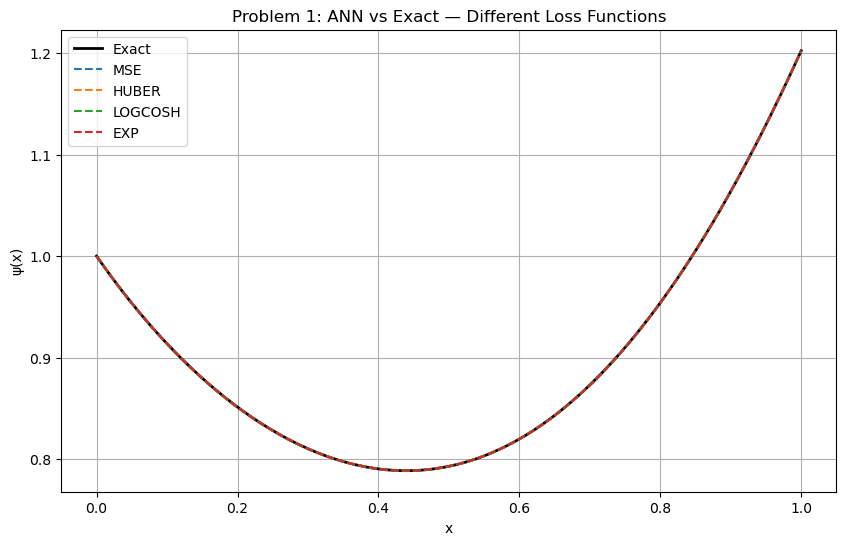

In [19]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(x_test, psi_exact, 'k', label='Exact', linewidth=2)

for loss_type in loss_types:
    pred = results[loss_type]['pred']
    plt.plot(x_test, pred, '--', label=loss_type.upper())

plt.title("Problem 1: ANN vs Exact — Different Loss Functions")
plt.xlabel("x")
plt.ylabel("ψ(x)")
plt.grid(True)
plt.legend()
plt.show()

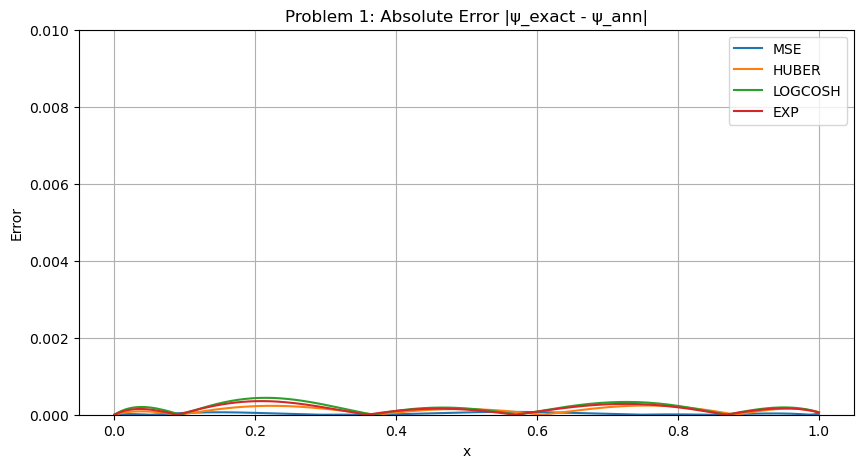

In [26]:
plt.figure(figsize=(10, 5))

for loss_type in loss_types:
    pred = results[loss_type]['pred']
    abs_error = np.abs(pred - psi_exact)
    plt.plot(x_test, abs_error, label=loss_type.upper())

plt.title("Problem 1: Absolute Error |ψ_exact - ψ_ann|")
plt.xlabel("x")
plt.ylabel("Error")
plt.grid(True)
plt.legend()
plt.ylim(0,0.01)
plt.show()

In [21]:
print("\n Final MSE Comparison:")
for k, v in sorted(results.items(), key=lambda x: x[1]['mse']):
    print(f"{k.upper():<8} → MSE = {v['mse']:.6e}")



 Final MSE Comparison:
MSE      → MSE = 1.430900e-09
HUBER    → MSE = 1.976847e-08
EXP      → MSE = 3.353377e-08
LOGCOSH  → MSE = 4.947133e-08
